In [54]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [55]:
DATASET_PATH ="D:\\machinelearning\\tetris\\data\\mini_speech_commands"
data_dir = "D:\\machinelearning\\tetris\\data\\mini_speech_commands"
print(data_dir)

D:\machinelearning\tetris\data\mini_speech_commands


In [56]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')] 
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'right' 'stop' 'up']


In [57]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6200 files belonging to 6 classes.
Using 4960 files for training.
Using 1240 files for validation.

label names: ['down' 'go' 'left' 'right' 'stop' 'up']


In [58]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [59]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [60]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [61]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


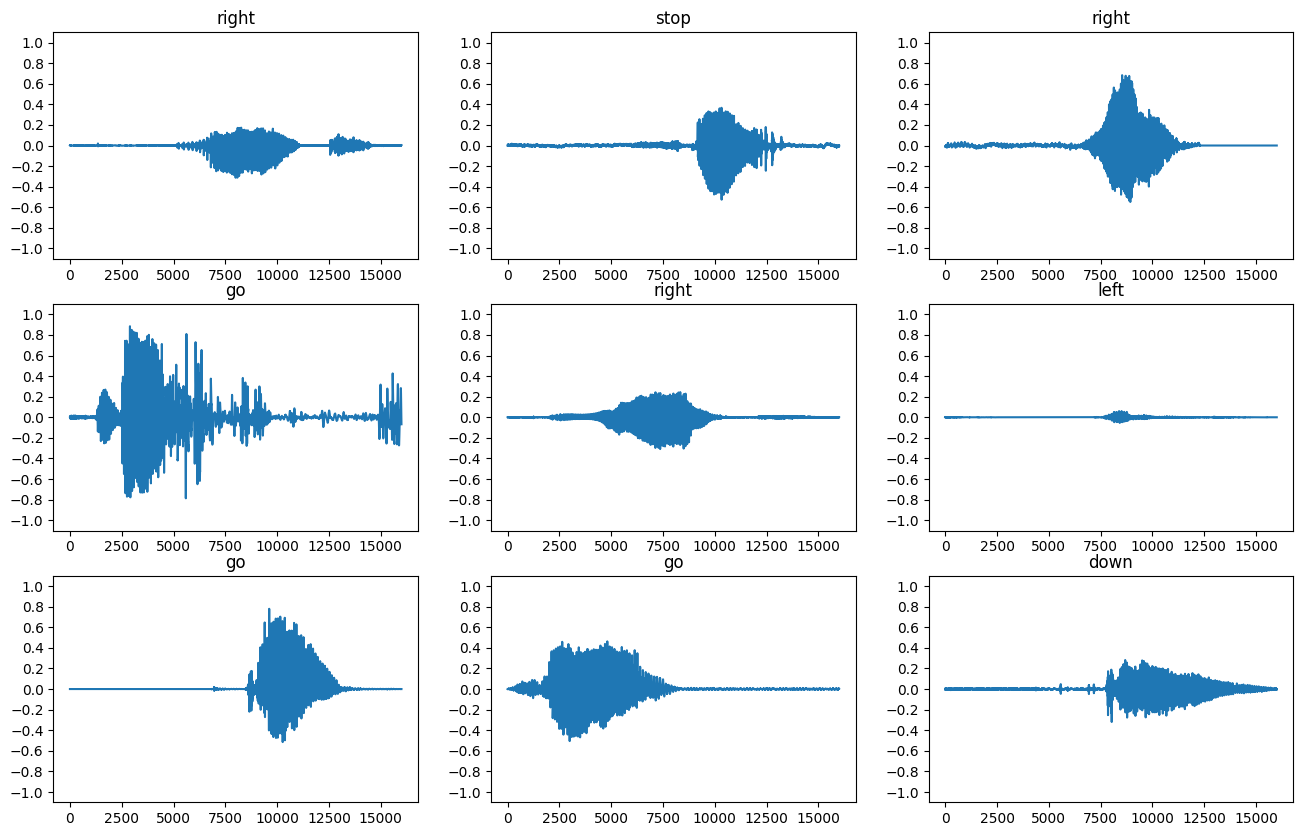

In [62]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [63]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [64]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [65]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

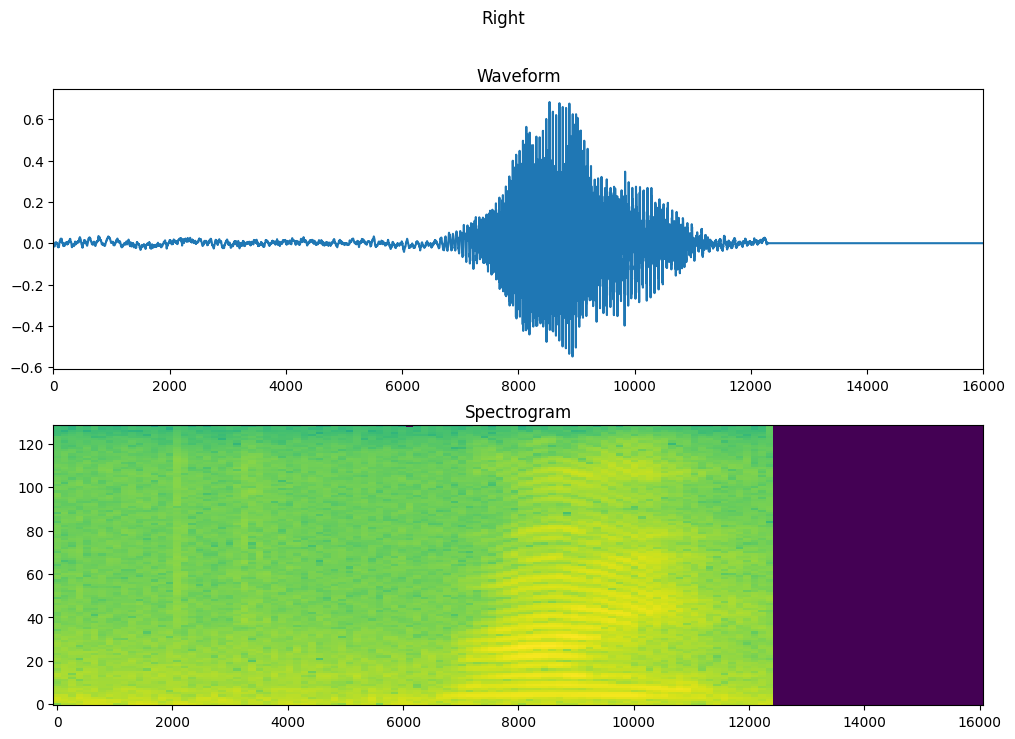

In [66]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [67]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [68]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [69]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

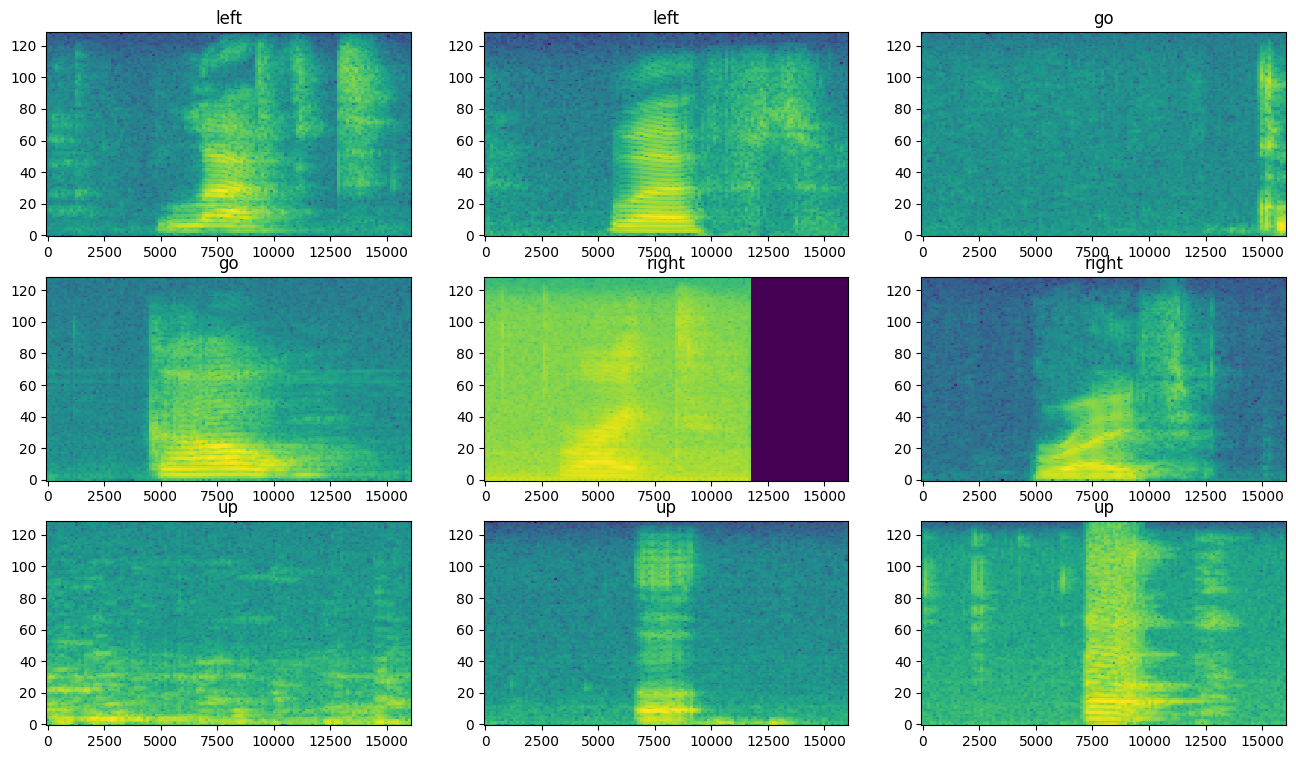

In [70]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [71]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [72]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [74]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/50
78/78 [==============================] - 81s 974ms/step - loss: 1.6961 - accuracy: 0.2867 - val_loss: 1.3753 - val_accuracy: 0.5633
Epoch 2/50
78/78 [==============================] - 45s 574ms/step - loss: 1.1743 - accuracy: 0.5641 - val_loss: 0.8721 - val_accuracy: 0.7217
Epoch 3/50
78/78 [==============================] - 47s 600ms/step - loss: 0.7565 - accuracy: 0.7393 - val_loss: 0.5555 - val_accuracy: 0.8317
Epoch 4/50
78/78 [==============================] - 47s 606ms/step - loss: 0.5330 - accuracy: 0.8125 - val_loss: 0.4092 - val_accuracy: 0.8650
Epoch 5/50
78/78 [==============================] - 44s 565ms/step - loss: 0.4379 - accuracy: 0.8490 - val_loss: 0.3934 - val_accuracy: 0.8683
Epoch 6/50
78/78 [==============================] - 51s 660ms/step - loss: 0.3425 - accuracy: 0.8804 - val_loss: 0.3348 - val_accuracy: 0.8817
Epoch 7/50
78/78 [==============================] - 51s 660ms/step - loss: 0.2618 - accuracy: 0.9113 - val_loss: 0.3084 - val_accuracy: 0.9100

In [75]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 [==============================] - 8s 684ms/step - loss: 0.2991 - accuracy: 0.9484


{'loss': 0.29907453060150146, 'accuracy': 0.948437511920929}

Predicted Label: left
tf.Tensor(
[5.5308033e-07 1.9110393e-09 9.9999809e-01 1.1247965e-06 9.6810091e-08
 1.7683108e-07], shape=(6,), dtype=float32)


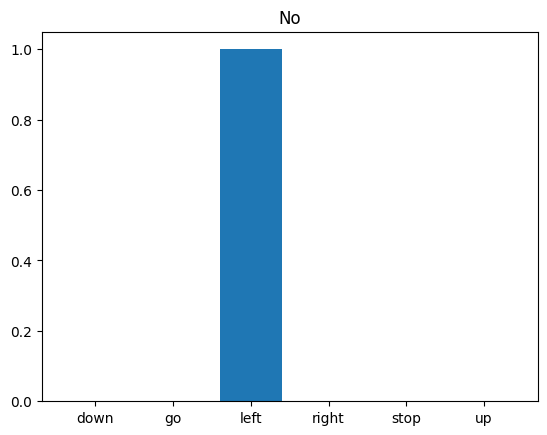

In [76]:
x ="D:\\machinelearning\\tetris\\data\\mini_speech_commands\\left\\recording_46.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'right', 'stop', 'up']
predicted_label_index = tf.argmax(prediction[0]).numpy()
predicted_label_name = x_labels[predicted_label_index]
print("Predicted Label:", predicted_label_name)
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
print( tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [81]:
tf.saved_model.save(model, "tetris2.0")
imported = tf.saved_model.load("tetris2.0")
print(imported)

INFO:tensorflow:Assets written to: tetris2.0\assets


INFO:tensorflow:Assets written to: tetris2.0\assets


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001C09F7A2F10>


squeezed x tf.Tensor(
[-0.01565552 -0.03390503 -0.03390503 ...  0.          0.
  0.        ], shape=(16000,), dtype=float32)
3
Predicted Label: right
tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)


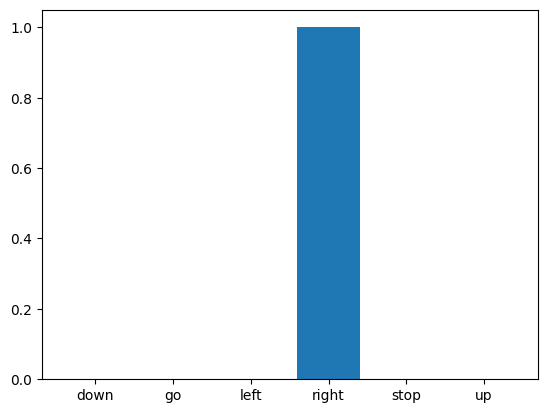

In [82]:
imported = tf.saved_model.load("tetris2.0")

x ="D:\\machinelearning\\tetris\\data\\mini_speech_commands\\right\\0c40e715_nohash_1.wav"


x = tf.io.read_file(str(x))

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
print('squeezed x',x)
x = get_spectrogram(x)
x = x[tf.newaxis,...]
prediction=imported(x)
x_labels = ['down', 'go', 'left', 'right', 'stop', 'up']
predicted_label_index = tf.argmax(prediction[0]).numpy()
print(predicted_label_index)
predicted_label_name = x_labels[predicted_label_index]
print("Predicted Label:", predicted_label_name)
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
print( tf.nn.softmax(prediction[0]))
plt.show()

something
Recording started...
Recording stopped
tf.Tensor([[ -633370.   1849801.2 -1277075. ]], shape=(1, 3), dtype=float32)
Predicted Label: left
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


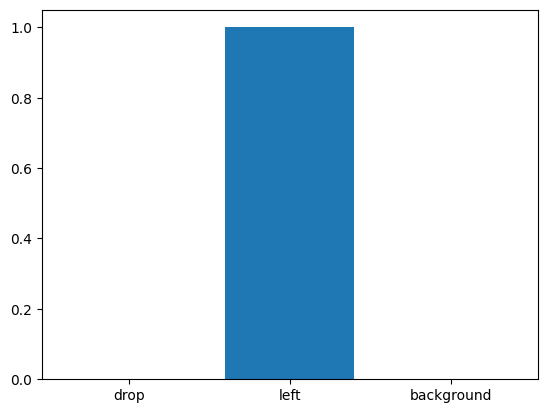

In [122]:
import pyaudio
import numpy as np
print('something')
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
imported = tf.saved_model.load("half1")
p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )
    print('Recording started...')

    frames = []
    seconds = 1
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)
    print("Recording stopped")

    stream.stop_stream()
    stream.close()
    p.terminate()  # Terminate PyAudio instance after recording
    
    # Convert recorded audio frames to numpy array
    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)

    # Convert numpy array to tensor
    audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    

    return audio_tensor



def terminate():
    p.terminate()
x=record_audio()

x = get_spectrogram(x)
x = x[tf.newaxis,...]
prediction=imported(x)
print(prediction)
x_labels = ['drop','left','background']
predicted_label_index = tf.argmax(prediction[0]).numpy()
predicted_label_name = x_labels[predicted_label_index]
print("Predicted Label:", predicted_label_name)
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
print( tf.nn.softmax(prediction[0]))
plt.show()

something
Listening for speech...
Recording started...
Recording stopped
RMS: 26.02959613593726
tf.Tensor([[ 80020.15    9195.823 -53863.73   11652.691 -63082.91  -72717.9  ]], shape=(1, 6), dtype=float32)
Predicted Label: down
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


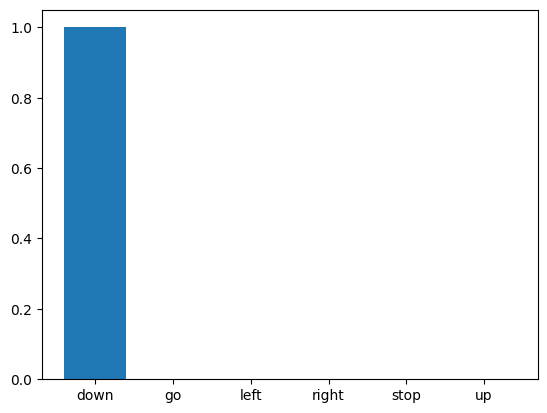

Paused. Press Ctrl+C to stop recording.
Listening for speech...
Recording started...
Recording stopped
RMS: 60.42431060839668
tf.Tensor([[-131226.38    14093.056  -65210.656 -107606.914   28331.799  130263.42 ]], shape=(1, 6), dtype=float32)
Predicted Label: up
tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32)


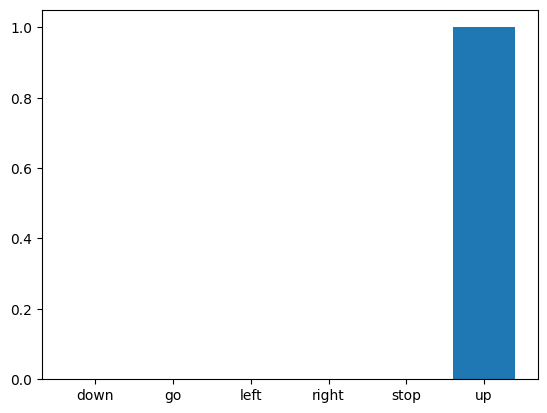

Paused. Press Ctrl+C to stop recording.
Listening for speech...
Recording started...
Recording stopped
RMS: 38.12743762698983
tf.Tensor([[  7627.127   15562.806  -12285.877   -8045.8477 -13678.005   -7908.1226]], shape=(1, 6), dtype=float32)
Predicted Label: go
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)


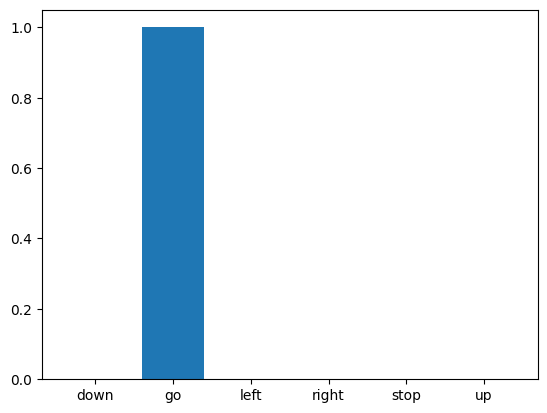

Paused. Press Ctrl+C to stop recording.
Listening for speech...
Recording started...
Recording stopped
RMS: 46.96364684519293
tf.Tensor([[  9612.75   78293.08  -79396.96  -36830.504 -34793.074 -13272.785]], shape=(1, 6), dtype=float32)
Predicted Label: go
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)


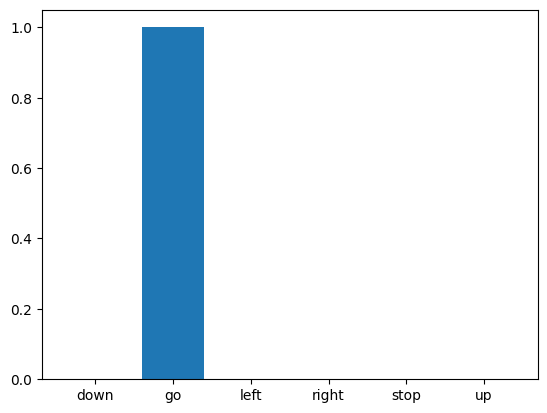

Paused. Press Ctrl+C to stop recording.
Listening for speech...
Recording started...
Recording stopped
RMS: 53.99703984942138
tf.Tensor([[ -4414.884   27746.215  -19497.084  -11806.679  -16208.023   -3350.2493]], shape=(1, 6), dtype=float32)
Predicted Label: go
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)


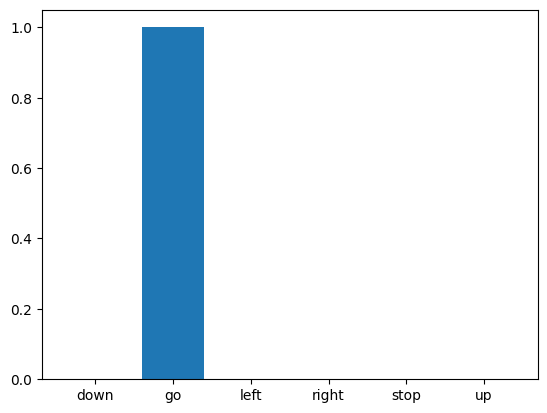

Paused. Press Ctrl+C to stop recording.
Recording stopped by user.


In [113]:
import pyaudio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
print('something')

FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000

p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )
    print('Recording started...')

    frames = []
    seconds = 1  # Duration of each recording segment
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)
        
    print("Recording stopped")

    stream.stop_stream()
    stream.close()
    
    # Convert recorded audio frames to numpy array
    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)
    
    if is_silent(audio_data):
        print("Input is silent. Returning None.")
        return None

    # Convert numpy array to tensor
    audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    return audio_tensor

def is_silent(audio_data):
    SILENCE_THRESHOLD = 0.1  # Adjust as needed
    rms = np.sqrt(np.mean(np.square(audio_data)))
    print("RMS:", rms)
    return rms < SILENCE_THRESHOLD

def terminate():
    p.terminate()

# Define your model and other necessary functions here (get_spectrogram, imported, etc.)

# Define your silence threshold
SILENCE_THRESHOLD = 35.0  # Adjust as needed

# In your main script
while True:
    print("Listening for speech...")
    x = record_audio()
    time.sleep(2)
    if x is not None:
        x = get_spectrogram(x)
        x = x[tf.newaxis,...]
        prediction = imported(x)
        print(prediction)
        x_labels = ['down', 'go', 'left', 'right', 'stop', 'up']
        predicted_label_index = tf.argmax(prediction[0]).numpy()
        predicted_label_name = x_labels[predicted_label_index]
        print("Predicted Label:", predicted_label_name)
        plt.bar(x_labels, tf.nn.softmax(prediction[0]))
        print(tf.nn.softmax(prediction[0]))
        plt.show()
    
    # Add a delay before starting the next recording
    print("Paused. Press Ctrl+C to stop recording.")
    try:
        time.sleep(2)  # Adjust the duration of the pause as needed
    except KeyboardInterrupt:
        print("Recording stopped by user.")
        break

# Clean up PyAudio
terminate()
